# MNIST dataset, digit recognition using my MLP implementation

In [139]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
y = y.astype(int)

X.shape, y.shape

((70000, 784), (70000,))

In [140]:
# normalize pixels in [-1,1] which is a common practice
X = 2.0 * X / 255 - 1

In [141]:
from sklearn.model_selection import train_test_split

# Divide into training, validation and testing
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=10000, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=5000, stratify=y_temp)

X_train.shape, X_valid.shape, X_test.shape

((55000, 784), (5000, 784), (10000, 784))

In [142]:
from neural_net_mlp import NeuralNetMLP

model = NeuralNetMLP(n_features=28*28,
                     n_hidden=50,
                     n_classes=10,
                     random_state=1310)

We will make a stochastic gradient descent.

In [143]:
import numpy as np


epochs = 50
minibatch_size = 100

def minibatch_generator(X, y, minibatch_size):
    indexes = np.arange(X.shape[0])
    np.random.shuffle(indexes)
    for i in range(0, len(indexes) - minibatch_size + 1, minibatch_size):
        batch_indexes = indexes[i:i + minibatch_size]
        yield X.iloc[batch_indexes], y.iloc[batch_indexes]

Now we define loss function and performance metric for the training process

In [144]:
def mse_loss(targets, probabs, num_labels=10):
    onehot_targets = model._one_hot_encode(targets, num_labels)
    return np.mean((onehot_targets - probabs) ** 2)

def accuracy(targets, pred_labels):
    return np.mean(targets == pred_labels)

Let's see the initial validation set MSE and accuracy

In [145]:
_, probabs = model.forward(X_valid)
mse = mse_loss(y_valid, probabs)
print(f'Initial validation MSE: {mse:.02f}')

pred_labels = np.argmax(probabs, axis=1) # select predicted labels which are equal to their index
accur = accuracy(y_valid, pred_labels)
print(f'Validation accuracy: {accur:.02f}')

Initial validation MSE: 0.47
Validation accuracy: 0.09


It makes sense that the accuracy is around 10% given that we have 10 possible classes.  

Let's now implement the training to get good results.

In [146]:
def compute_mse_acc(nn, X, y, n_labels=10, minibatch_size=100):
    """
    Compute MSE and accuracy incrementally by iterating over the dataset one minibatch at a time for efficiency
    """
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    for i, (features, targets) in enumerate(minibatch_gen):
        _, probas = nn.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        onehot_targets = nn._one_hot_encode(targets, n_classes=n_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss
    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc


def train(model, X_train, y_train, X_valid, y_valid, epochs, learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for epoch in range(epochs):
        minibatches = minibatch_generator(X_train, y_train, minibatch_size)
        
        for X_train_minibatch, y_train_minibatch in minibatches:
            # Get outputs
            a_h, a_out = model.forward(X_train_minibatch)
            
            # Compute gradients
            d_loss__d_w_out, d_loss__d_b_out, \
                d_loss__d_w_h, d_loss__d_b_h = model.backward(X_train_minibatch,
                                                              a_h,
                                                              a_out,
                                                              y_train_minibatch)
            # Update weights
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        train_mse, train_acc = compute_mse_acc(model, X_train, y_train)
        
        valid_mse, valid_acc = compute_mse_acc(model, X_valid, y_valid)
        
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {epoch+1:03d}/{epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')
        
    return epoch_loss, epoch_train_acc, epoch_valid_acc

The `train()` function iteratively trains the model over multiple epochs using stochastic gradient descent (SGD). In each epoch, the training data is divided into mini-batches, which are processed sequentially. For each mini-batch, the model computes its outputs via the `.forward()` method, then calculates loss gradients using the `.backward()` method. The weights are updated by subtracting the product of the learning rate and the gradients, effectively reducing the loss. After processing all mini-batches in an epoch, the function evaluates the model's performance by calculating the loss and accuracy on both the training and test sets, allowing for monitoring of the training progress.

After tuning learning rate a bit, I've come to these great results.

In [147]:
np.random.seed(123) # for the training set shuffle
epoch_loss, epoch_train_acc, epoch_valid_acc = train(model, X_train, y_train, X_valid, y_valid,
                                                     epochs=50,
                                                     learning_rate=1)

Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 60.09% | Valid Acc: 58.64%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 80.70% | Valid Acc: 79.70%
Epoch: 003/050 | Train MSE: 0.03 | Train Acc: 84.15% | Valid Acc: 83.20%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 86.54% | Valid Acc: 85.36%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 87.46% | Valid Acc: 86.64%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 88.40% | Valid Acc: 87.46%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 89.05% | Valid Acc: 88.18%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 89.67% | Valid Acc: 88.66%
Epoch: 009/050 | Train MSE: 0.02 | Train Acc: 90.14% | Valid Acc: 89.44%
Epoch: 010/050 | Train MSE: 0.02 | Train Acc: 90.51% | Valid Acc: 89.62%
Epoch: 011/050 | Train MSE: 0.02 | Train Acc: 90.57% | Valid Acc: 89.70%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 90.94% | Valid Acc: 90.04%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 91.42% | Valid Acc: 90.32%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 91.48

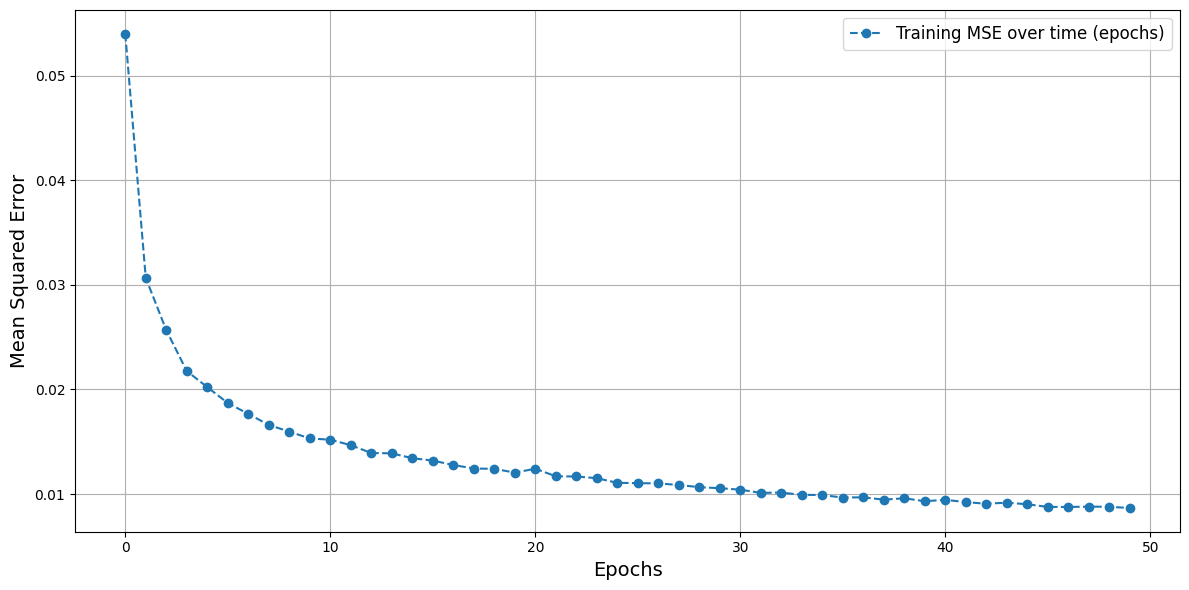

In [153]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(range(50), epoch_loss, label='Training MSE over time (epochs)', marker='o', linestyle='--')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Mean Squared Error', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()

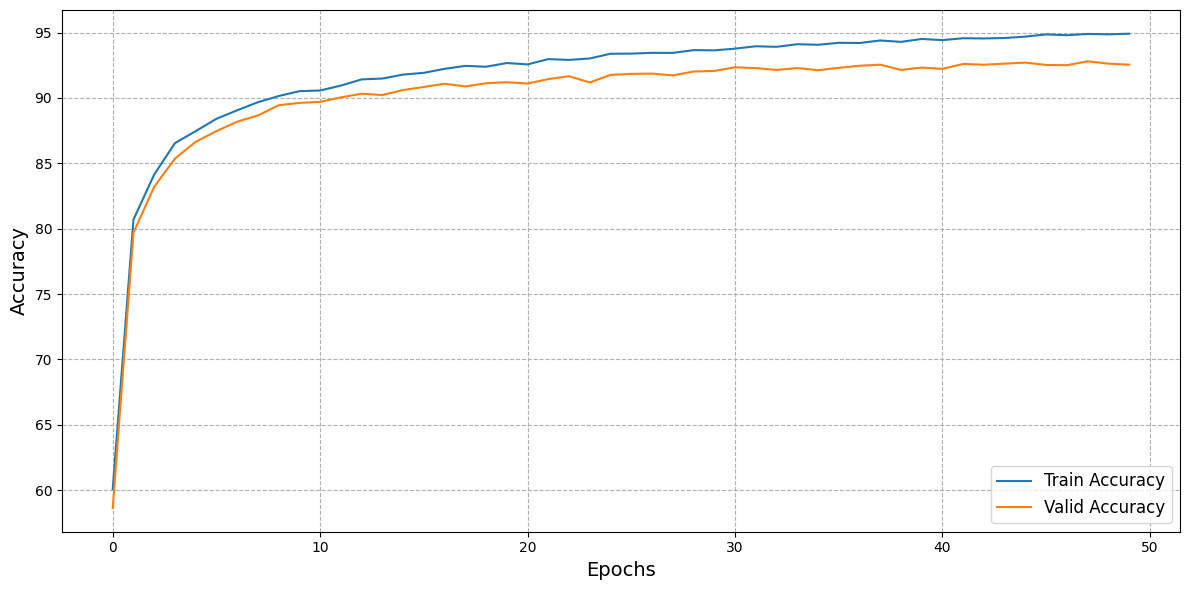

In [156]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(range(50), epoch_train_acc, label='Train Accuracy')
plt.plot(range(50), epoch_valid_acc, label='Valid Accuracy')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True, linestyle='--')
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()

Finally, let's evaluate the performance on the test dataset:

In [158]:
test_mse, test_acc = compute_mse_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.02f}%')

Test accuracy: 92.65%
